Project Goal
- Predict who is likely to receive the H1N1 vaccine.

Import the necessary libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [2]:

#Load the two csv files for training data
x = pd.read_csv("./Data/training_set_features.csv")
y = pd.read_csv("./Data/training_set_labels.csv")

df = pd.merge(x, y, on = "respondent_id")



Pick target variable that the model is to predict
We are predicting h1n1 vaccine. 0 = no, 1 = yes

In [3]:
target = "h1n1_vaccine" # Whether someone got the h1n1 vaccine or not

y = df[target]
X = df.drop(columns=['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])

Split the data for training and testing

In [4]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [5]:
#Identify column types whether numerical or categorical
numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()


In [6]:
#Fill missing values in numeric columns with the median
#Fill missing values in categorical columns with missing and perform encoding

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])



In [7]:
#Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])


In [8]:
# Fit transformer on training data only then transform to both training and test data to ensure no data leakage
X_train_clean = preprocessor.fit_transform(X_train)

X_test_clean = preprocessor.transform(X_test)

print("Training data shape:", X_train_clean.shape)
print("Test data shape:", X_test_clean.shape)



Training data shape: (21365, 112)
Test data shape: (5342, 112)


Building the baseline model - A logistic regression model

Accuracy: 0.8366
Recall (class 1): 0.4405
F1-score (class 1): 0.5339
ROC-AUC: 0.8293

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      4207
           1       0.68      0.44      0.53      1135

    accuracy                           0.84      5342
   macro avg       0.77      0.69      0.72      5342
weighted avg       0.82      0.84      0.82      5342


Confusion Matrix:
 [[3969  238]
 [ 635  500]]


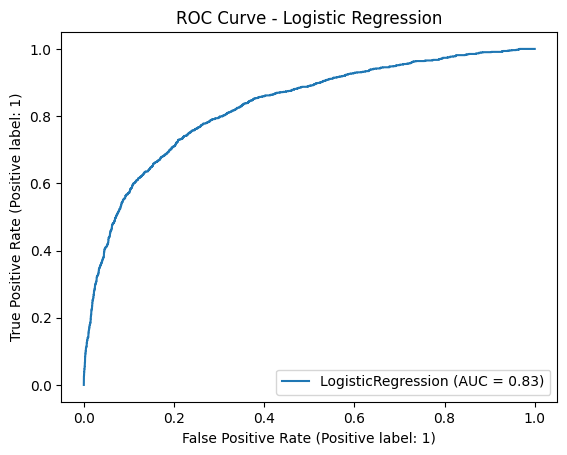

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

# Train a basic logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_clean, y_train)

# Make predictions
y_pred = logreg.predict(X_test_clean)
y_proba = logreg.predict_proba(X_test_clean)[:, 1]  # Probabilities for 1- People who got the vaccine

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall (class 1): {classification_report(y_test, y_pred, output_dict=True)['1']['recall']:.4f}")
print(f"F1-score (class 1): {classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']:.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC curve
RocCurveDisplay.from_estimator(logreg, X_test_clean, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()


Recall	0.4405	The model correctly identified 44.05% of the actual vaccine-takers.
F1-score	0.5339	Balance between precision and recall — a mid-level score.
Precision	0.68	When the model predicted someone would get vaccinated, it was right 68% of the time.

Model is missing more than half of the people who got the vaccine

0	Did NOT take vaccine	4,207	Model performs very well
1	Did take vaccine	1,135	Model did not perform very well(low recall)

Confusion Matrix
True Negatives (3969)	Correctly predicted non-vaccinated	
False Positives (238)	Predicted vaccinated but they were not	
False Negatives (635)	Missed people who did get vaccinated 	
True Positives (500)	Correctly predicted vaccinated



Building a different model - Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_clean, y_train)

# Predict on test data
y_pred_dt = dt_model.predict(X_test_clean)
y_proba_dt = dt_model.predict_proba(X_test_clean)[:, 1]  


Evaluate the model

In [11]:
print("Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Recall (class 1):", recall_score(y_test, y_pred_dt))
print("F1-score (class 1):", f1_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))


Decision Tree Classifier Metrics:
Accuracy: 0.7484088356420816
Recall (class 1): 0.4511013215859031
F1-score (class 1): 0.43243243243243246
ROC-AUC: 0.6398601449859632

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4207
           1       0.42      0.45      0.43      1135

    accuracy                           0.75      5342
   macro avg       0.63      0.64      0.64      5342
weighted avg       0.76      0.75      0.75      5342


Confusion Matrix:
[[3486  721]
 [ 623  512]]


Accuracy	0.748	74.8% of all predictions were correct (lower than logistic regression: 83.7%).
Recall (Class 1)	0.451	Captured 45.1% of actual vaccine-takers (slightly better than logistic's 44.1%).
F1-score (Class 1)	0.432	Balance between precision and recall for class 1 — lower than logistic's 0.534.
ROC-AUC	0.640	Poorer ranking ability compared to logistic regression's 0.829.

721 false positives: Model predicted they got the vaccine, but they didn’t.

623 false negatives: Model predicted they didn't get vaccinated, but they did.
                 LR   DT
Accuracy	0.837	0.748
Recall (class 1)	0.441 0.451
F1-score	0.534	0.432
ROC-AUC 0.829	0.640

Third Model - Logistic Regression with Hyperparameter Tuning


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid = {
    'classifier__penalty': ['l1', 'l2'],                
    'classifier__C': [0.01, 0.1, 1, 10],                 
    'classifier__solver': ['liblinear'],               
    'classifier__class_weight': [None, 'balanced'],     
    'classifier__max_iter': [500, 1000]                 
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',     
    verbose=2,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


Evaluate the tuned model

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84      4207
           1       0.47      0.72      0.57      1135

    accuracy                           0.77      5342
   macro avg       0.69      0.75      0.71      5342
weighted avg       0.82      0.77      0.79      5342

Confusion Matrix:
 [[3300  907]
 [ 315  820]]
ROC-AUC Score: 0.8292516458304756


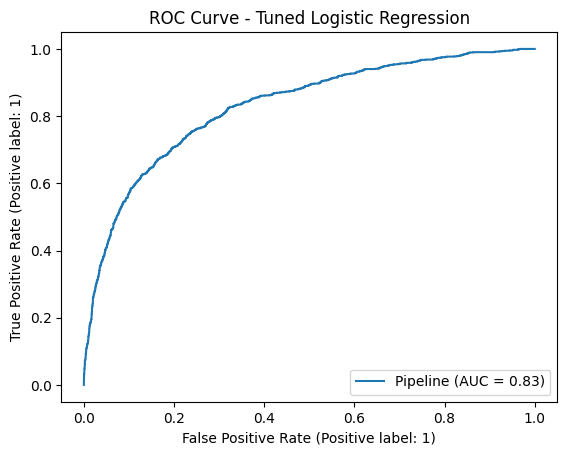

In [15]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve - Tuned Logistic Regression")
plt.show()


The tuned logistic regression model is significantly better aligned with the goal of the project of predicting people who are likely to take the vaccine.
The model ->
Increased recall from 0.44 → 0.72

Retained a strong ROC-AUC of 0.83

Accepted lower precision, which is a fair tradeoff in public health screening where missing positives is more harmful than over-predicting them